# 03a_overlap_clusters_HSC_LSK

calculated overlap of different clusters:  
- HSC compare Replicate 1 vs Replicate 2  
- HSC vs LSK compare the two clusters  


Pathway enrichment in the clusters using:
- Reactome and GO:BP
- curated from Rodriguez 2020 and Cabezas 2017 (functional HSC publications)

done with this docker image:

docker run --rm -d --name test_eva -p 8883:8888 -e JUPYTER_ENABLE_LAB=YES -v /Users/efast/Documents/:/home/jovyan/work gseapy:0.10.4 

In [1]:
#load some packages that are needed for plotting + computation

import math
from matplotlib import pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import numpy as np
import gseapy as gp
from math import floor, log10
%matplotlib inline

from gprofiler import GProfiler
from helper_functions import *

Creating directory /home/jovyan/.config/bioservices 


## Cluster overlap

In [2]:
# define total number of genes for background dataset - genes that can be measured in scRNAseq - based on the single cell objects
# LSK was 13,827, HSC was 14,408 - take 14,000

total_n = 14000

###  HSC vs MPP

In [3]:
LT = pd.read_csv('/home/jovyan/work/Z_TRASH/write/all_HSC_clusters_final_all_genes.csv')
MPP = pd.read_csv('/home/jovyan/work/Z_TRASH/write/all_MPP_clusters_final_all_genes.csv')

In [4]:
# make dataframe with gene overlaps for supp data
df_final = []

MPP_cls = ['Primed', 'Metabolism', 'Progenitor', 'Cell-cycle', 'Acute-Activation', 'Interferon', 'Interferon cell-cycle','Myeloid']
LT_cls = ['Metabolism', 'Activated', 'Interferon', 'Acute-Activation', 'Cell-cycle']


LT_cl = 'Quiescent'
column_name = 'HSC_' + LT_cl
df_final = pd.DataFrame(columns=['gene', column_name])
LT_column_pvalue = LT_cl + '_p'
LT_column_fch = LT_cl + '_l'
LT_column_name = LT_cl + '_n'
LT_sort_column = LT_cl + '_s'
    
list1 = LT.sort_values(by=LT_sort_column, ascending=False)[LT_column_name][:100].tolist()
df_final['gene'] = list1
df_final[column_name] = 1      
    
for LT_cl in LT_cls:
    list1_df = []
    column_name = 'HSC_' + LT_cl
    list1_df = pd.DataFrame(columns=['gene', column_name])
    LT_column_pvalue = LT_cl + '_p'
    LT_column_fch = LT_cl + '_l'
    LT_column_name = LT_cl + '_n'
    LT_sort_column = LT_cl + '_s'
    
    list1 = LT.sort_values(by=LT_sort_column, ascending=False)[LT_column_name][:100].tolist()
    list1_df['gene'] = list1
    list1_df[column_name] = 1       
    
    df_final = df_final.merge(list1_df, how='outer', on='gene')   

for MPP_cl in MPP_cls:
    list1_df = []
    column_name = 'LSK_' + MPP_cl
    list1_df = pd.DataFrame(columns=['gene', column_name])
    MPP_column_pvalue = MPP_cl + '_p'
    MPP_column_fch = MPP_cl + '_l'
    MPP_column_name = MPP_cl + '_n'
    MPP_sort_column = MPP_cl + '_s'
    
    list1 = MPP.sort_values(by=MPP_sort_column, ascending=False)[MPP_column_name][:100].tolist()
    list1_df['gene'] = list1
    list1_df[column_name] = 1       
    
    df_final = df_final.merge(list1_df, how='outer', on='gene')

    
df_final = df_final.fillna(0)
#replace 0 and 1 with 'True' and 'False'
df_final.replace(0, False, inplace=True)
df_final.replace(1, True, inplace=True)

df_final.to_csv('/home/jovyan/work/Z_TRASH/write/HSC_LSK_OL.csv', index=False, header=True)

In [5]:
MPP_cls = ['Primed', 'Metabolism', 'Progenitor', 'Cell-cycle', 'Acute-Activation', 'Interferon', 'Interferon cell-cycle','Myeloid']
LT_cls = ['Metabolism', 'Quiescent', 'Activated', 'Interferon', 'Acute-Activation', 'Cell-cycle']

results_df_list =[]
results_df = pd.DataFrame()

p_value_df_list = []
p_value_df = pd.DataFrame()

for MPP_cl in MPP_cls:
    results_df_list =[]
    p_value_df_list =[]
    MPP_column_pvalue = MPP_cl + '_p'
    MPP_column_fch = MPP_cl + '_l'
    MPP_column_name = MPP_cl + '_n'
    MPP_sort_column = MPP_cl + '_s'
    
    list1 = MPP.sort_values(by=MPP_sort_column, ascending=False)[MPP_column_name][:100].tolist()
     
    for LT_cl in LT_cls:
        LT_column_pvalue = LT_cl + '_p'
        LT_column_fch = LT_cl + '_l'
        LT_column_name = LT_cl + '_n'
        LT_sort_column = LT_cl + '_s'
        
        list2 = LT.sort_values(by=LT_sort_column, ascending=False)[LT_column_name][:100].tolist()
        
        intersection = len(list(set(list1).intersection(list2)))
        only_MPP = len(list1) - intersection
        only_LT = len(list2) - intersection
        rest = total_n - (only_MPP + only_LT + intersection)
       
        oddsratio, pvalue = stats.fisher_exact([[intersection, only_MPP], [only_LT, rest]], alternative='greater')
        
        results_df_list.append(intersection)
        p_value_df_list.append(pvalue)
    
    p_value_df_series = pd.Series(p_value_df_list)
    p_value_df = p_value_df.append(p_value_df_series, ignore_index=True)
    
    results_df_list = pd.Series(results_df_list)
    results_df = results_df.append(results_df_list, ignore_index=True)

p_value_df, rej = multiple_testing_correction(ps = p_value_df, 
                                                    alpha=0.01,
                                                    method='benjamini-hochberg')
p_value_df = pd.DataFrame(p_value_df) 

In [6]:
results_df

,0,1,2,3,4,5
0,1.0,32.0,0.0,0.0,5.0,0.0
1,33.0,0.0,0.0,0.0,0.0,41.0
2,0.0,42.0,30.0,3.0,5.0,0.0
3,2.0,0.0,1.0,0.0,0.0,50.0
4,0.0,16.0,21.0,0.0,47.0,0.0
5,1.0,4.0,2.0,86.0,1.0,0.0
6,0.0,2.0,1.0,70.0,1.0,20.0
7,3.0,0.0,2.0,1.0,3.0,0.0


In [7]:
results_df.index = ['Primed', 'Metabolism', 'Progenitor', 'Cell-cycle', 'Acute-Activation', 'Interferon', 'Interferon cell-cycle','Myeloid']
results_df.columns = ['Metabolism', 'Quiescent', 'Activated', 'Interferon', 'Acute-Activation', 'Cell-cycle']

p_value_df.index = ['Primed', 'Metabolism', 'Progenitor', 'Cell-cycle', 'Acute-Activation', 'Interferon', 'Interferon cell-cycle','Myeloid']
p_value_df.columns = ['Metabolism', 'Quiescent', 'Activated', 'Interferon', 'Acute-Activation', 'Cell-cycle']

In [8]:
results_df = results_df.reindex(['Progenitor', 'Primed', 'Metabolism', 'Cell-cycle', 'Interferon cell-cycle', 
                 'Interferon', 'Acute-Activation','Myeloid'])
results_df = results_df[['Quiescent', 'Activated','Metabolism','Cell-cycle', 'Interferon',
                                     'Acute-Activation']]


p_value_df = p_value_df.reindex(['Progenitor', 'Primed', 'Metabolism', 'Cell-cycle', 'Interferon cell-cycle', 
                 'Interferon', 'Acute-Activation','Myeloid'])
p_value_df = p_value_df[['Quiescent', 'Activated','Metabolism','Cell-cycle', 'Interferon',
                                     'Acute-Activation']]

In [9]:
p_value_df

,Quiescent,Activated,Metabolism,Cell-cycle,Interferon,Acute-Activation
Progenitor,6.591340e-66,3.699092e-41,1.000000e+00,1.000000e+00,9.267614e-02,2.538396e-03
Primed,5.108839e-45,1.000000e+00,8.490338e-01,1.000000e+00,1.000000e+00,2.538396e-03
Metabolism,1.000000e+00,1.000000e+00,5.910785e-47,9.176633e-64,1.000000e+00,1.000000e+00
Cell-cycle,1.000000e+00,8.490338e-01,3.492098e-01,2.238608e-84,1.000000e+00,1.000000e+00
Interferon cell-cycle,3.492098e-01,8.490338e-01,1.000000e+00,2.384094e-23,1.632485e-138,8.490338e-01
Interferon,1.821592e-02,3.492098e-01,8.490338e-01,1.000000e+00,7.882784e-192,8.490338e-01
Acute-Activation,4.356286e-17,5.773806e-25,1.000000e+00,1.000000e+00,1.000000e+00,2.656455e-77
Myeloid,1.000000e+00,3.492098e-01,9.267614e-02,1.000000e+00,8.490338e-01,9.267614e-02


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text xticklabel objects>)

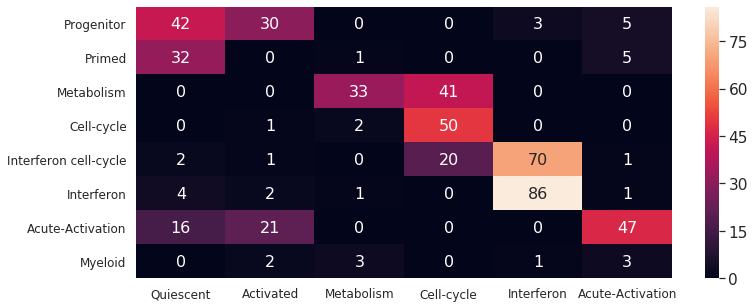

In [10]:
sns.set(font_scale=1.4)

plt.figure(figsize=(12,5))
sns.heatmap(results_df, annot=True, annot_kws={"size": 16})
plt.yticks(rotation=0, fontsize = 12) 
plt.xticks(rotation=-0, fontsize = 12)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text xticklabel objects>)

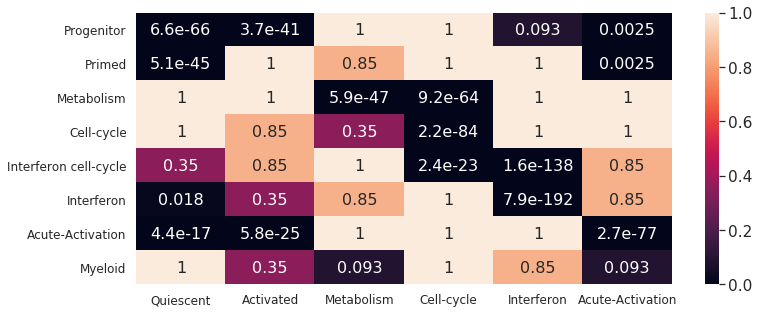

In [11]:
sns.set(font_scale=1.4)

plt.figure(figsize=(12,5))
sns.heatmap(p_value_df, annot=True, annot_kws={"size": 16})
plt.yticks(rotation=0, fontsize = 12) 
plt.xticks(rotation=-0, fontsize = 12)

In [12]:
p_value_mask_sig = p_value_df > 0.01
p_value_mask_nonsig = p_value_df < 0.01

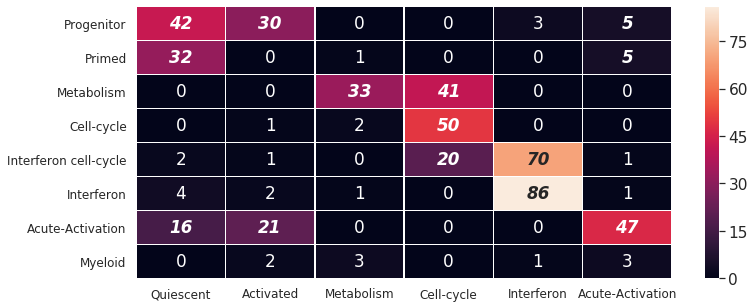

In [13]:
sns.set(font_scale=1.4)

plt.figure(figsize=(12,5))
#sns.heatmap(results_df, annot=True, annot_kws={"size": 16}, mask = p_value_mask)
plt.yticks(rotation=0, fontsize = 12) 
plt.xticks(rotation=-0, fontsize = 12)


sns.heatmap(results_df,
            mask = p_value_mask_sig,
            linewidth=0.5,
            annot_kws={"style": "italic", "weight": "bold"},
            annot=True)


sns.heatmap(results_df,
            mask = p_value_mask_nonsig,
            linewidth=0.5,
            cbar=False,
            annot=True)

plt.savefig("/home/jovyan/work/Z_TRASH/figures/overlap_clusters_MPP_LT_July21.pdf", dpi=300, bbox_inches='tight')

### HSC replicates

In [14]:
LT_o = pd.read_csv('/home/jovyan/work/Z_TRASH/write/old_LT_clusters.csv')
LT_n = pd.read_csv('/home/jovyan/work/Z_TRASH/write/new_LT_clusters.csv')

In [15]:
LT_n

,Quiescent_n,Quiescent_s,Activated_n,Activated_s,Metabolism_n,Metabolism_s,Interferon_n,Interferon_s
0,Txnip,22.294632,Nr4a1,48.622177,Mcm3,30.333117,Iigp1,11.872274
1,Clec2d,22.164490,Hes1,42.123000,Mcm6,30.019775,Oasl2,11.382495
2,Rsrp1,15.520906,Junb,40.118330,Dut,27.477684,Isg15,10.487597
3,Mycn,10.915593,H3f3b,35.973620,Mcm7,27.346546,Gm4951,10.316038
4,Gm16141,10.791975,Ier2,35.940273,Ptma,26.834818,Xaf1,10.102091
...,...,...,...,...,...,...,...,...
95,Gm17473,4.859793,Hspa5,11.107095,Mrpl18,12.149610,Mov10,3.403670
96,Tia1,4.844184,Mapk6,11.087958,Ezh2,11.920335,Irf1,3.339669
97,Guf1,4.830636,Ptp4a1,11.061901,Ssrp1,11.885616,Tmem140,3.315809
98,Rpl18a,4.829197,Dyrk3,10.982834,Banf1,11.880320,Irf9,3.287476


In [16]:
LT_o

,Quiescent_n,Quiescent_s,Activated_n,Activated_s,Metabolism_n,Metabolism_s,Interferon_n,Interferon_s
0,Ifitm1,12.053443,Fos,43.154907,Ran,13.484201,Ifi44,9.094761
1,Txnip,11.644235,Nr4a1,40.405636,Ptma,12.692476,Ifit1,7.284892
2,Ltb,10.128781,Dusp1,32.103840,Ranbp1,12.207068,Oasl2,6.306534
3,B2m,9.902033,Zfp36,27.303663,Actb,12.151029,Isg15,6.053075
4,Rsrp1,9.900495,H3f3b,26.812187,Cdca7,11.639833,Stat1,5.587022
...,...,...,...,...,...,...,...,...
95,Rabac1,3.986369,Dpm1,5.414113,Chchd2,5.953577,Zufsp,1.836767
96,Rpl19,3.983870,Ftl1,5.345505,Pgls,5.951105,Il27,1.827309
97,Ifi47,3.958037,Arpc3,5.325624,Hnrnpa1,5.950543,Gpatch8,1.822311
98,Tmem63b,3.947126,Atf4,5.249719,Tkt,5.931892,H2-T22,1.815005


In [17]:
# make dataframe with gene overlaps for supp data
df_final = []
LT_o_cls = ['Activated', 'Metabolism', 'Interferon']
LT_n_cls = ['Quiescent', 'Activated', 'Metabolism', 'Interferon']

LT_o_cl = 'Quiescent'
column_name = LT_o_cl + '_Replicate1'
df_final = pd.DataFrame(columns=['gene', column_name])
LT_o_column_pvalue = LT_o_cl + '_p'
LT_o_column_fch = LT_o_cl + '_l'
LT_o_column_name = LT_o_cl + '_n'
LT_o_sort_column = LT_o_cl + '_s'
    
list1 = LT_o.sort_values(by=LT_o_sort_column, ascending=False)[LT_o_column_name][:100].tolist()
df_final['gene'] = list1
df_final[column_name] = 1      
    
for LT_o_cl in LT_o_cls:
    list1_df = []
    column_name = LT_o_cl + '_Replicate1'
    list1_df = pd.DataFrame(columns=['gene', column_name])
    LT_o_column_pvalue = LT_o_cl + '_p'
    LT_o_column_fch = LT_o_cl + '_l'
    LT_o_column_name = LT_o_cl + '_n'
    LT_o_sort_column = LT_o_cl + '_s'
    
    list1 = LT_o.sort_values(by=LT_o_sort_column, ascending=False)[LT_o_column_name][:100].tolist()
    list1_df['gene'] = list1
    list1_df[column_name] = 1       
    
    df_final = df_final.merge(list1_df, how='outer', on='gene')   

for LT_n_cl in LT_n_cls:
    list1_df = []
    column_name = LT_n_cl + '_Replicate2'
    list1_df = pd.DataFrame(columns=['gene', column_name])
    LT_n_column_pvalue = LT_n_cl + '_p'
    LT_n_column_fch = LT_n_cl + '_l'
    LT_n_column_name = LT_n_cl + '_n'
    LT_n_sort_column = LT_n_cl + '_s'
    
    list1 = LT_n.sort_values(by=LT_n_sort_column, ascending=False)[LT_n_column_name][:100].tolist()
    list1_df['gene'] = list1
    list1_df[column_name] = 1       
    
    df_final = df_final.merge(list1_df, how='outer', on='gene')

    
df_final = df_final.fillna(0)
#replace 0 and 1 with 'True' and 'False'
df_final.replace(0, False, inplace=True)
df_final.replace(1, True, inplace=True)

df_final.to_csv('/home/jovyan/work/Z_TRASH/write/HSC_Repl1_2_OL.csv', index=False, header=True)

In [19]:
LT_o_cls = ['Quiescent', 'Activated', 'Metabolism', 'Interferon']
LT_n_cls = ['Quiescent', 'Activated', 'Metabolism', 'Interferon']

results_df_list =[]
results_df = pd.DataFrame()

p_value_df_list = []
p_value_df = pd.DataFrame()

for LT_o_cl in LT_o_cls:
    
    results_df_list =[]
    p_value_df_list =[]
    LT_o_column_pvalue = LT_o_cl + '_p'
    LT_o_column_fch = LT_o_cl + '_l'
    LT_o_column_name = LT_o_cl + '_n'
    LT_o_sort_column = LT_o_cl + '_s'
    
    list1 = LT_o.sort_values(by=LT_o_sort_column, ascending=False)[LT_o_column_name][:100].tolist()      
        
    for LT_n_cl in LT_n_cls:
        
        LT_column_pvalue = LT_n_cl + '_p'
        LT_column_fch = LT_n_cl + '_l'
        LT_column_name = LT_n_cl + '_n'
        LT_sort_column = LT_n_cl + '_s'
        
        list2 = LT_n.sort_values(by=LT_sort_column, ascending=False)[LT_column_name][:100].tolist()   
        
        intersection = len(list(set(list1).intersection(list2)))
       
        only_LT_o = len(list1) - intersection
        only_LT = len(list2) - intersection
        rest = total_n - (only_LT_o + only_LT + intersection)
       
        oddsratio, pvalue = stats.fisher_exact([[intersection, only_LT_o], [only_LT, rest]], alternative='greater')
        
        results_df_list.append(intersection)
        p_value_df_list.append(pvalue)
    
    p_value_df_series = pd.Series(p_value_df_list)
    p_value_df = p_value_df.append(p_value_df_series, ignore_index=True)
    
    results_df_list = pd.Series(results_df_list)
    results_df = results_df.append(results_df_list, ignore_index=True)

p_value_df, rej = multiple_testing_correction(ps = p_value_df, 
                                                    alpha=0.01,
                                                    method='benjamini-hochberg')
p_value_df = pd.DataFrame(p_value_df) 

In [20]:
results_df

,0,1,2,3
0,28.0,0.0,0.0,10.0
1,0.0,69.0,0.0,0.0
2,0.0,0.0,53.0,0.0
3,2.0,3.0,0.0,57.0


In [21]:
results_df.columns = ['Quiescent_1', 'Activated_1', 'Metabolism_1', 'Interferon_1']
results_df.index = ['Quiescent_2', 'Activated_2', 'Metabolism_2', 'Interferon_2']


p_value_df.columns = ['Quiescent_1', 'Activated_1', 'Metabolism_1', 'Interferon_1']
p_value_df.index = ['Quiescent_2', 'Activated_2', 'Metabolism_2', 'Interferon_2']

In [22]:
p_value_df

,Quiescent_1,Activated_1,Metabolism_1,Interferon_1
Quiescent_2,1.769149e-37,1.000000e+00,1.000000e+00,7.115794e-09
Activated_2,1.000000e+00,1.099619e-135,1.000000e+00,1.000000e+00
Metabolism_2,1.000000e+00,1.000000e+00,2.760764e-92,1.000000e+00
Interferon_2,3.658388e-01,9.267614e-02,1.000000e+00,2.170552e-102


(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text xticklabel objects>)

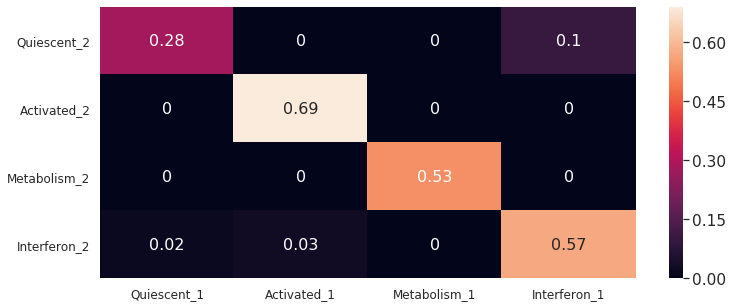

In [23]:
sns.set(font_scale=1.4)

plt.figure(figsize=(12,5))
sns.heatmap(results_df/100, annot=True, annot_kws={"size": 16})
plt.yticks(rotation=0, fontsize = 12) 
plt.xticks(rotation=-0, fontsize = 12)

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text xticklabel objects>)

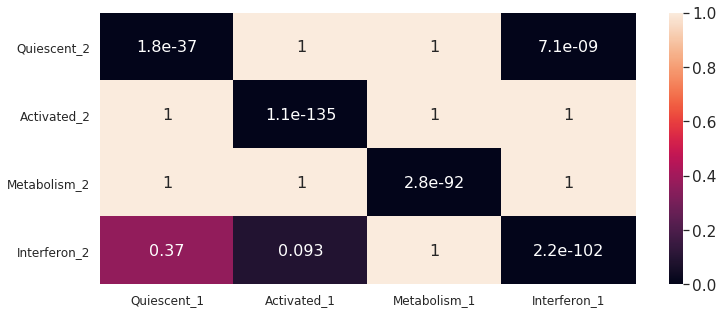

In [24]:
sns.set(font_scale=1.4)

plt.figure(figsize=(12,5))
sns.heatmap(p_value_df, annot=True, annot_kws={"size": 16})
plt.yticks(rotation=0, fontsize = 12) 
plt.xticks(rotation=-0, fontsize = 12)

In [25]:
p_value_mask_sig = p_value_df > 0.01
p_value_mask_nonsig = p_value_df < 0.01

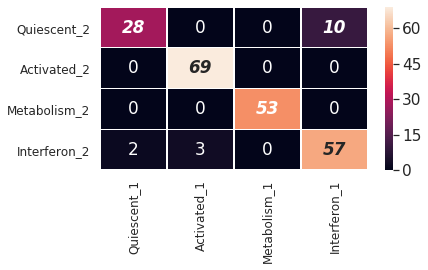

In [26]:
sns.set(font_scale=1.4)

plt.figure(figsize=(6,3))
#sns.heatmap(results_df, annot=True, annot_kws={"size": 16}, mask = p_value_mask)
plt.yticks(rotation=0, fontsize = 12) 
plt.xticks(rotation=-0, fontsize = 12)


sns.heatmap(results_df,
            mask = p_value_mask_sig,
            linewidth=0.5,
            annot_kws={"style": "italic", "weight": "bold"},
            annot=True)


sns.heatmap(results_df,
            mask = p_value_mask_nonsig,
            linewidth=0.5,
            cbar=False,
            annot=True)

plt.savefig("/home/jovyan/work/Z_TRASH/figures/overlap_clusters_LT_replicates_July21.pdf", dpi=300, bbox_inches='tight')

## Cluster enrich - HSC

In [27]:
#HSC signatures
df = pd.read_csv('/home/jovyan/work/Z_TRASH/raw_data/Rodriguez_gene_sig.csv')
Rodriguez_dic = df.to_dict('list')

In [28]:
cluster_genes = LT

df = pd.DataFrame(columns=['primerid', 'specific'])

cl_list = ['Metabolism', 'Quiescent', 'Activated', 'Interferon', 'Acute-Activation', 'Cell-cycle']

df_temp =pd.DataFrame(columns=['primerid', 'specific', 'score'])

for cl in cl_list:
    results_df = pd.DataFrame(columns=['primerid', 'specific', 'score'])
    column_name = cl + '_n'
    sort_column = cl + '_s'
    column_pval = cl + '_p'
    column_fch = cl + '_l'
    
    
    genelist = cluster_genes[(cluster_genes[column_pval] < 0.05) & \
                             (cluster_genes[column_fch] > math.log2(1))][column_name].tolist()
    
    scorelist = cluster_genes[(cluster_genes[column_pval] < 0.05) & \
                             (cluster_genes[column_fch] > math.log2(1))][sort_column].tolist()
    
    
    string_list = [cl] * len(genelist)
    
    results_df['primerid'] = genelist
    results_df['specific'] = string_list
    results_df['score'] = scorelist
    
    df_temp = df_temp.append(results_df, ignore_index=True)

df_temp = df_temp.sort_values(by='score', ascending=False) # this is to get rid of duplicates
df_temp = df_temp.drop_duplicates(subset=['primerid'], keep='first') #keep the ones with the highest score

cl_list = ['Metabolism', 'Quiescent', 'Activated', 'Interferon', 'Acute-Activation', 'Cell-cycle']
#top_genes = 100

for cl in cl_list:
    results_df = pd.DataFrame()
        
    #genelist = df_temp[df_temp['specific']==cl].sort_values(by='score', ascending=False)['primerid'][:top_genes].tolist()
    genelist = df_temp[df_temp['specific']==cl].sort_values(by='score', ascending=False)['primerid'].tolist()
    
    string_list = [cl] * len(genelist)
    results_df['specific'] = string_list
    results_df['primerid'] = genelist
    
    df = df.append(results_df, ignore_index=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [29]:
df_save = pd.DataFrame(columns =['Cluster', 'Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names'])

for cl in cl_list:
    
    df_final = pd.DataFrame(columns =['Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names'])

    sources = ["GO:BP"]
    top_genes = 100

    gene_list = df[df['specific']==cl]['primerid'].tolist()
    gene_list = ribofilter(gene_list)
    temp_df = pathway_enrich_genes_new(gene_list[:top_genes], sources).head(3)

    temp_df = col_select(temp_df)

    df_final = df_final.append(temp_df, ignore_index=True)

    sources = ["REAC"]

    gene_list = df[df['specific']==cl]['primerid'].tolist()
    gene_list = ribofilter(gene_list)
    temp_df = pathway_enrich_genes_new(gene_list[:top_genes], sources).head(3)

    temp_df = col_select(temp_df)

    df_final = df_final.append(temp_df, ignore_index=True)

    enr_res = gp.enrichr(gene_list=gene_list[:top_genes],
                             organism='Mouse',
                             gene_sets= Rodriguez_dic,
                             background = total_n,    
                             description='pathway',
                             cutoff = 0.05)

    temp_df = enr_res.results[enr_res.results['Adjusted P-value'] < 0.01]
    temp_df = temp_df.sort_values(by = 'Adjusted P-value', axis=0, ascending=True).head(6)

    temp_df['Gene Overlap'] = temp_df['Overlap']
    temp_df['Gene names'] = temp_df['Genes']

    # extract conditions
    pw_list = []
    origin_list = []
    for index, row in temp_df.iterrows():
        pw = 0
        origin = 0   
        pw = row['Term'].split('999')[1]
        origin = row['Term'].split('999')[0]  
        pw_list.append(pw)
        origin_list.append(origin)

    temp_df['Origin'] = pw_list
    temp_df['Pathway'] = origin_list

    temp_df = temp_df[['Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names']]

    df_final = df_final.append(temp_df, ignore_index=True)
    df_final['Adjusted P-value'] = df_final['Adjusted P-value'].apply(lambda x: round(x, 1 - int(floor(log10(abs(x))))))
    df_final['Cluster'] = cl
    df_final = df_final[['Cluster', 'Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names']]
    df_save = df_save.append(df_final, ignore_index=True)

df_save.to_csv('/home/jovyan/work/Z_TRASH/write/HSC_cluster_enrichment.csv', index=False, header=True)

## Cluster enrich - LSK

In [30]:
#HSC signatures
df = pd.read_csv('/home/jovyan/work/Z_TRASH/raw_data/Rodriguez_gene_sig.csv')
Rodriguez_dic = df.to_dict('list')

In [31]:
cluster_genes = MPP

df = pd.DataFrame(columns=['primerid', 'specific'])

cl_list = ['Primed', 'Metabolism', 'Progenitor', 'Cell-cycle', 'Acute-Activation', 'Interferon', 'Interferon cell-cycle','Myeloid']

df_temp =pd.DataFrame(columns=['primerid', 'specific', 'score'])

for cl in cl_list:
    results_df = pd.DataFrame(columns=['primerid', 'specific', 'score'])
    column_name = cl + '_n'
    sort_column = cl + '_s'
    column_pval = cl + '_p'
    column_fch = cl + '_l'
    
    
    genelist = cluster_genes[(cluster_genes[column_pval] < 0.05) & \
                             (cluster_genes[column_fch] > math.log2(1))][column_name].tolist()
    
    scorelist = cluster_genes[(cluster_genes[column_pval] < 0.05) & \
                             (cluster_genes[column_fch] > math.log2(1))][sort_column].tolist()
    
    
    string_list = [cl] * len(genelist)
    
    results_df['primerid'] = genelist
    results_df['specific'] = string_list
    results_df['score'] = scorelist
    
    df_temp = df_temp.append(results_df, ignore_index=True)

df_temp = df_temp.sort_values(by='score', ascending=False) # this is to get rid of duplicates
df_temp = df_temp.drop_duplicates(subset=['primerid'], keep='first') #keep the ones with the highest score


for cl in cl_list:
    results_df = pd.DataFrame()
        
    #genelist = df_temp[df_temp['specific']==cl].sort_values(by='score', ascending=False)['primerid'][:top_genes].tolist()
    genelist = df_temp[df_temp['specific']==cl].sort_values(by='score', ascending=False)['primerid'].tolist()
    
    string_list = [cl] * len(genelist)
    results_df['specific'] = string_list
    results_df['primerid'] = genelist
    
    df = df.append(results_df, ignore_index=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [32]:
df_save = pd.DataFrame(columns =['Cluster', 'Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names'])

for cl in cl_list:
    
    df_final = pd.DataFrame(columns =['Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names'])

    sources = ["GO:BP"]
    top_genes = 100

    gene_list = df[df['specific']==cl]['primerid'].tolist()
    gene_list = ribofilter(gene_list)
    temp_df = pathway_enrich_genes_new(gene_list[:top_genes], sources).head(3)

    temp_df = col_select(temp_df)

    df_final = df_final.append(temp_df, ignore_index=True)

    sources = ["REAC"]

    gene_list = df[df['specific']==cl]['primerid'].tolist()
    gene_list = ribofilter(gene_list)
    temp_df = pathway_enrich_genes_new(gene_list[:top_genes], sources).head(3)

    temp_df = col_select(temp_df)

    df_final = df_final.append(temp_df, ignore_index=True)

    enr_res = gp.enrichr(gene_list=gene_list[:top_genes],
                             organism='Mouse',
                             gene_sets= Rodriguez_dic,
                             background = total_n,    
                             description='pathway',
                             cutoff = 0.05)

    temp_df = enr_res.results[enr_res.results['Adjusted P-value'] < 0.01]
    temp_df = temp_df.sort_values(by = 'Adjusted P-value', axis=0, ascending=True).head(6)

    temp_df['Gene Overlap'] = temp_df['Overlap']
    temp_df['Gene names'] = temp_df['Genes']

    # extract conditions
    pw_list = []
    origin_list = []
    for index, row in temp_df.iterrows():
        pw = 0
        origin = 0   
        pw = row['Term'].split('999')[1]
        origin = row['Term'].split('999')[0]  
        pw_list.append(pw)
        origin_list.append(origin)

    temp_df['Origin'] = pw_list
    temp_df['Pathway'] = origin_list

    temp_df = temp_df[['Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names']]

    df_final = df_final.append(temp_df, ignore_index=True)
    df_final['Adjusted P-value'] = df_final['Adjusted P-value'].apply(lambda x: round(x, 1 - int(floor(log10(abs(x))))))
    df_final['Cluster'] = cl
    df_final = df_final[['Cluster', 'Origin', 'Pathway', 'Gene Overlap', 'Adjusted P-value', 'Gene names']]
    df_save = df_save.append(df_final, ignore_index=True)

df_save.to_csv('/home/jovyan/work/Z_TRASH/write/MPP_cluster_enrichment.csv', index=False, header=True)

2021-08-31 13:13:19,771 Warning: No enrich terms using library CUSTOM140609510958856 when cutoff = 0.05


In [33]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.10.25-linuxkit
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 0.25.3
numpy            : 1.17.3
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 41.6.0.post20191101
Cython           : 0.29.14
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.6.3
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.9.0
pandas_datareader: None
bs4              : 4.8.1
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : 4.6.3
matplotlib      

In [34]:
! pip list

Package                Version            
---------------------- -------------------
alembic                1.3.0              
anndata                0.7.1              
appdirs                1.4.4              
async-generator        1.10               
attrs                  19.3.0             
backcall               0.1.0              
beautifulsoup4         4.8.1              
bioservices            1.7.11             
bleach                 3.1.0              
blinker                1.4                
bokeh                  1.3.4              
cellbrowser            0.7.7              
certifi                2020.4.5.1         
certipy                0.1.3              
cffi                   1.13.2             
chardet                3.0.4              
Click                  7.0                
cloudpickle            1.2.2              
colorama               0.4.4              
colorlog               5.0.1              
conda                  4.7.12             
conda-packa